<a href="https://colab.research.google.com/github/Ricardo-Jaramillo/Python-Tensorflow/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-09-16 19:32:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-16 19:32:36 (63.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (test samples of Tweets labelled as diaster or not diaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started/data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unizip the data
unzip_data('nlp_getting_started.zip')

--2023-09-16 19:32:46--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.20.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2023-09-16 19:32:46 (99.8 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python:

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df) - 5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index + 5].itertuples():
  _, text, target = row
  print(f'Target: {target}', '(real diaster)' if target > 0 else '(not real diaster)')
  print(f'Text:\n{text}\n')
  print('---\n')

Target: 0 (not real diaster)
Text:
What the fuck was that. There was a loud bang and a flash of light outside. I'm pretty sure I'm not dead but what the hell??

---

Target: 1 (real diaster)
Text:
'Three #people were #killed when a severe #rainstorm in the #Italian #Alps caused a #landslide' http://t.co/hAXJ6Go2ac

---

Target: 1 (real diaster)
Text:
RÌ©union Debris Is Almost Surely From Flight 370 Officials Say - New York Times http://t.co/VFbW3NyO9L

---

Target: 1 (real diaster)
Text:
The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/hCKxJ8eukt

---

Target: 0 (not real diaster)
Text:
OKAY I CAN'T FIND IT SO I'M KINDA PANICKING

---



### Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation split
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
len(train_df_shuffled)

7613

In [ ]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None, # create groups of n-words?
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=None # how long do you want your sequences to be?
                                    # pad_to_max_tokens=True
                                    )

In [ ]:
len(train_sentences[0].split())

7

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
        \n\nVectorized version:')
text_vectorizer([random_sentence])

Original text:
 @todd_calfee so @mattburgener wanted to see that info on blight u got        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[7511,   28,    1,  974,    5,   99,   16, 1077,   11,  748,  142,
         100,    0,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The paramteters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_lenght` = lenght of the sequences being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             embeddings_initializer='uniform',
                             input_length=max_length # how long is each input
                             )
embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
      \n\n Embedded version:')

# Embedded the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 #DroughtMonitor: Moderate or worse #drought ? to ~27% of contig USA; affects ~80M people. http://t.co/YBE9JQoznR http://t.co/328SzflEtZ      

 Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03890628,  0.00744004,  0.01882396, ...,  0.00415885,
          0.02928661,  0.02566976],
        [ 0.02099841,  0.01017598, -0.04274676, ..., -0.0188965 ,
         -0.02789215, -0.02636856],
        [ 0.00148686,  0.0365701 , -0.02510555, ...,  0.02244418,
         -0.01498025, -0.03826023],
        ...,
        [ 0.03219957,  0.04204709, -0.01682334, ..., -0.04754446,
          0.01667674,  0.02364454],
        [-0.03890628,  0.00744004,  0.01882396, ...,  0.00415885,
          0.02928661,  0.02566976],
        [-0.03890628,  0.00744004,  0.01882396, ...,  0.00415885,
          0.02928661,  0.02566976]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.03890628,  0.00744004,  0.01882396, -0.02919124, -0.02958207,
         0.02974024, -0.02943102,  0.04882736, -0.04669726, -0.04785786,
         0.0195982 , -0.00080298, -0.01549101, -0.03818452,  0.04689244,
         0.02630172,  0.01955098, -0.03822346, -0.04556141, -0.03773811,
         0.04785353,  0.01875288, -0.03741684,  0.03259179,  0.04270936,
        -0.02454472,  0.00702562,  0.0246704 , -0.02644625, -0.01787553,
         0.00641615,  0.04151892,  0.00075144,  0.01733125,  0.02685909,
         0.03243384, -0.01417614,  0.04375562,  0.03505118, -0.00335294,
        -0.03846116, -0.04886306, -0.03202622, -0.03391155,  0.03816542,
         0.00513115,  0.02543689, -0.01486863,  0.04148806,  0.00925498,
        -0.01137159, -0.00156672, -0.04794357,  0.00965188, -0.0075107 ,
         0.00531084,  0.01663074,  0.01446435,  0.01794784,  0.00433985,
        -0.01643658,  0.01466223, -0.00351257,  0.02201951,  0.03548435,
  

## Modelling a text dataset (running a series of experiments)

Now we've a got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* **Model 0**: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model (RNN)
* **Model 3**: GRU model (RNN)
* **Model 4**: Bidirectional-LSTM model (RNN)
* **Model 5**: 1D Convolutional Neural Network (CNN)
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* **Model 7**: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow

* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes usinf the TF-IDF formula to convert our words to numbers.

> **Note**: It's common practice to use non-Deep Learning algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # convert words to numbers using tfidf
                    ('clf', MultinomialNB()) # model the text
                  ])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

> For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  '''
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  '''
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall, f1-score using 'weighted' average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results



In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation='sigmoid')(x) # Create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20230916-193253
Epoch 1/5
215/215 [==============================] - 15s 52ms/step - loss: 0.6076 - accuracy: 0.7024 - val_loss: 0.5375 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 10s 44ms/step - loss: 0.4404 - accuracy: 0.8216 - val_loss: 0.4699 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 10s 48ms/step - loss: 0.3453 - accuracy: 0.8641 - val_loss: 0.4581 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 10s 47ms/step - loss: 0.2832 - accuracy: 0.8923 - val_loss: 0.4674 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.2364 - accuracy: 0.9118 - val_loss: 0.4807 - val_accuracy: 0.7808


In [ ]:
# Check the results()
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4807 - accuracy: 0.7808


[0.4807460904121399, 0.7808399200439453]

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 1s 6ms/step


(762, 1)

In [ ]:
# Look at a single prediction
model_1_pred_probs[0]

array([0.41226882], dtype=float32)

In [ ]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.41226882],
       [0.84282243],
       [0.997784  ],
       [0.14460157],
       [0.1053509 ],
       [0.94419825],
       [0.9102362 ],
       [0.99374676],
       [0.9648154 ],
       [0.31160522]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label  format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [ ]:
# Calculate our model_1_results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.08398950131233,
 'precision': 0.783783808499639,
 'recall': 0.7808398950131233,
 'f1': 0.7783998521836788}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# Looks like our baseline is out performing our first deep learning model...
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Get the weight matrix of embedding layer
# (These are the numerical representations of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embedding themselves: https://www.tensorflow.org/text/guide/word_embeddings


In [ ]:
# Create embedding files (we got this from TensorFlow's word embeddins documentation
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> **Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture: https://www.youtube.com/watch?v=SEnXr6v2ifU
- Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

 ### Model 2: LSTM

 LSTM = long short term memory (one of the most popular LSTM cells)

 Our structure of an RNN typucally looks like this:

 ```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
 ```

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to return_sequences
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230916-193353
Epoch 1/5
215/215 [==============================] - 22s 73ms/step - loss: 0.2220 - accuracy: 0.9188 - val_loss: 0.5597 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 17s 78ms/step - loss: 0.1562 - accuracy: 0.9423 - val_loss: 0.5960 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 15s 71ms/step - loss: 0.1249 - accuracy: 0.9552 - val_loss: 0.6787 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 16s 75ms/step - loss: 0.1019 - accuracy: 0.9612 - val_loss: 0.8110 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 16s 75ms/step - loss: 0.0824 - accuracy: 0.9680 - val_loss: 1.0034 - val_accuracy: 0.7703


In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 2s 20ms/step


array([[4.8623895e-03],
       [7.9855746e-01],
       [9.9981612e-01],
       [3.7089080e-02],
       [4.8493783e-04],
       [9.9939400e-01],
       [9.4119948e-01],
       [9.9988049e-01],
       [9.9977857e-01],
       [4.8341817e-01]], dtype=float32)

In [ ]:
# Convert model 2 preds probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.03412073490814,
 'precision': 0.7739543961790544,
 'recall': 0.7703412073490814,
 'f1': 0.7673435495786338}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN component is the GRU or **gated recurrent unit**.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# print(x.shape)
# x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
# print(x.shape)
# x = layers.LSTM(42, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(99)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230916-193526
Epoch 1/5
215/215 [==============================] - 14s 45ms/step - loss: 0.1591 - accuracy: 0.9383 - val_loss: 0.7812 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0788 - accuracy: 0.9710 - val_loss: 0.9389 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0650 - accuracy: 0.9727 - val_loss: 1.0232 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0558 - accuracy: 0.9783 - val_loss: 1.2080 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0491 - accuracy: 0.9764 - val_loss: 1.2436 - val_accuracy: 0.7769


In [ ]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[5.1285542e-04],
       [7.1965128e-01],
       [9.9989015e-01],
       [7.1430758e-02],
       [6.2478248e-05],
       [9.9969459e-01],
       [8.4920418e-01],
       [9.9996048e-01],
       [9.9987125e-01],
       [4.5173851e-01]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.69028871391076,
 'precision': 0.7789562668302826,
 'recall': 0.7769028871391076,
 'f1': 0.7747522807746444}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

In [ ]:
# Build a bidirectional  RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_Bidirectional')

In [ ]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [ ]:
# Compile model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230916-193614
Epoch 1/5
215/215 [==============================] - 18s 57ms/step - loss: 0.1076 - accuracy: 0.9691 - val_loss: 0.9658 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 12s 56ms/step - loss: 0.0535 - accuracy: 0.9752 - val_loss: 1.1519 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 14s 63ms/step - loss: 0.0441 - accuracy: 0.9788 - val_loss: 1.3078 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 17s 80ms/step - loss: 0.0413 - accuracy: 0.9819 - val_loss: 1.4461 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 16s 72ms/step - loss: 0.0397 - accuracy: 0.9810 - val_loss: 1.6091 - val_accuracy: 0.7625


In [ ]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[8.61412287e-03],
       [8.08214426e-01],
       [9.99991834e-01],
       [1.19687326e-01],
       [1.23493810e-05],
       [9.99797344e-01],
       [9.22156274e-01],
       [9.99995589e-01],
       [9.99991655e-01],
       [9.99266028e-01]], dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.24671916010499,
 'precision': 0.7626600366229389,
 'recall': 0.7624671916010499,
 'f1': 0.7611077640788777}

In [ ]:
model_3_results

{'accuracy': 77.69028871391076,
 'precision': 0.7789562668302826,
 'recall': 0.7769028871391076,
 'f1': 0.7747522807746444}

### Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our image data but now we're foing to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(['this is a test sentence'])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1, # default
                        activation='relu',
                        padding='same') # default = 'valid', the output is smaller than the input shape, 'same' means output is same shape as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to 'get the most important feature' or 'get the feature with the highest value'

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [ ]:
# Create 1-dimendional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation='relu',
                  padding='valid')(x)
x = layers.GlobalMaxPooling1D()(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile Conv1D
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20230916-193743
Epoch 1/5
215/215 [==============================] - 8s 33ms/step - loss: 0.1247 - accuracy: 0.9590 - val_loss: 0.8922 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0754 - accuracy: 0.9708 - val_loss: 1.0340 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0603 - accuracy: 0.9758 - val_loss: 1.2191 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 6s 30ms/step - loss: 0.0570 - accuracy: 0.9774 - val_loss: 1.1946 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0515 - accuracy: 0.9781 - val_loss: 1.2193 - val_accuracy: 0.7559


In [ ]:
# Make som predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[1.0139490e-01],
       [1.7128696e-01],
       [9.9981993e-01],
       [1.6852379e-02],
       [3.2970473e-08],
       [9.8773420e-01],
       [8.4305871e-01],
       [9.9989486e-01],
       [9.9999905e-01],
       [8.0108386e-01]], dtype=float32)

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.59055118110236,
 'precision': 0.7573698742202679,
 'recall': 0.7559055118110236,
 'f1': 0.7535524954357875}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [ ]:
sample_sentence

"There's a flood in my street!"

In [ ]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,
                       'When you can the universal sentence encoder on a sentence, it turns it into numbers.'])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encode_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                       input_shape=[],
                                       dtype=tf.string,
                                       trainable=False,
                                       name='USE')

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encode_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230916-193848
Epoch 1/5
215/215 [==============================] - 9s 19ms/step - loss: 0.5047 - accuracy: 0.7902 - val_loss: 0.4508 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4155 - accuracy: 0.8151 - val_loss: 0.4397 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4012 - accuracy: 0.8240 - val_loss: 0.4325 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3930 - accuracy: 0.8273 - val_loss: 0.4287 - val_accuracy: 0.8189
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3863 - accuracy: 0.8304 - val_loss: 0.4260 - val_accuracy: 0.8202


In [ ]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 12ms/step


array([[0.1958501 ],
       [0.7978691 ],
       [0.9906699 ],
       [0.21025111],
       [0.7452609 ],
       [0.75033855],
       [0.9844738 ],
       [0.97921836],
       [0.9440064 ],
       [0.09019846]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8223219905078891,
 'recall': 0.8202099737532809,
 'f1': 0.8188242643827762}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
len(train_df_shuffled)

7613

### Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we wi'll train it on 10% of the data.

In [ ]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% of the data, outperforms model_6 train on 100% of data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [ ]:
# Making a better dataset split (no data leakage)
from sklearn.model_selection import train_test_split

train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)
len(train_sentences_10_percent), len(train_labels_10_percent)

(686, 686)

In [ ]:
train_sentences_10_percent[:10], len(train_sentences_10_percent)

(array(['Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak o... http://t.co/3hTJ2PypSg #News #check #follow',
        "@Jones94Kyle now I've said all this he's dead and no one else dies",
        '@argentings WE COULD HAVE HAD IT AAAAAAALLLL I\x89Ûªm not even on that season and I\x89Ûªm devastated',
        "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern China by S\x89Û_ http://t.co/0XCb7yeqmw",
        "So when r u getting married'@Foxy__Siren: Oh finally Jennifer Aniston got married??????... I'm so happy for her ??????'",
        'Real people. True stories. Real pain &amp; suffering. #displaced #RefugeesMatter #Syria  https://t.co/OEZ7O9AB2C',
        'dust storm in riyadh ????',
        "@AlexAllTimeLow awwww they're on an airplane accident and they're gonna die what a cuties ???? good job!",
        '@joshcorman  #infosec rather you knew it or not your a firefighter  now days  you often  

In [ ]:
train_labels_10_percent[:10], len(train_labels_10_percent)

(array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1]), 686)

In [ ]:
# Check the number of each label in the updated training data subset
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [ ]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [ ]:
# Let's build a model the same as model_6
model_7 = tf.keras.models.clone_model(model_6)
model_7._name = 'model_7_USE'

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary (will be the same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit the model to the 10% training data subset
model_7.fit(train_sentences_10_percent,
            train_labels_10_percent,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   'tf_sentence_encoder_10_percent_correct_split')])

Saving TensorBoard log files to: model_logs/tf_sentence_encoder_10_percent_correct_split/20230916-193920
Epoch 1/5
22/22 [==============================] - 4s 55ms/step - loss: 0.6690 - accuracy: 0.7012 - val_loss: 0.6476 - val_accuracy: 0.7139
Epoch 2/5
22/22 [==============================] - 1s 30ms/step - loss: 0.5985 - accuracy: 0.7974 - val_loss: 0.5918 - val_accuracy: 0.7454
Epoch 3/5
22/22 [==============================] - 1s 30ms/step - loss: 0.5245 - accuracy: 0.8076 - val_loss: 0.5412 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4607 - accuracy: 0.8294 - val_loss: 0.5086 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4187 - accuracy: 0.8353 - val_loss: 0.4913 - val_accuracy: 0.7795


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 13ms/step


array([[0.27761754],
       [0.7890368 ],
       [0.9048379 ],
       [0.32092318],
       [0.56569606],
       [0.83956033],
       [0.8306256 ],
       [0.84644467],
       [0.8390184 ],
       [0.1215983 ]], dtype=float32)

In [ ]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'precision': 0.7829461349391948,
 'recall': 0.7795275590551181,
 'f1': 0.7768651797484589}

In [ ]:
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8223219905078891,
 'recall': 0.8202099737532809,
 'f1': 0.8188242643827762}

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'baseline': baseline_results,
                                  '1_simple_dense':model_1_results,
                                  '2_lstm': model_2_results,
                                  '3_gru': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv1d': model_5_results,
                                  '6_tf_hub_use_encoder': model_6_results,
                                  '7_tf_hub_use_encoder_10_percent': model_7_results}).transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.083990,0.783784,0.780840,0.778400
2_lstm,77.034121,0.773954,0.770341,0.767344
3_gru,77.690289,0.778956,0.776903,0.774752
4_bidirectional,76.246719,0.762660,0.762467,0.761108
5_conv1d,75.590551,0.757370,0.755906,0.753552
6_tf_hub_use_encoder,82.020997,0.822322,0.820210,0.818824
7_tf_hub_use_encoder_10_percent,77.952756,0.782946,0.779528,0.776865


In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.780840,0.783784,0.780840,0.778400
2_lstm,0.770341,0.773954,0.770341,0.767344
3_gru,0.776903,0.778956,0.776903,0.774752
4_bidirectional,0.762467,0.762660,0.762467,0.761108
5_conv1d,0.755906,0.757370,0.755906,0.753552
6_tf_hub_use_encoder,0.820210,0.822322,0.820210,0.818824
7_tf_hub_use_encoder_10_percent,0.779528,0.782946,0.779528,0.776865


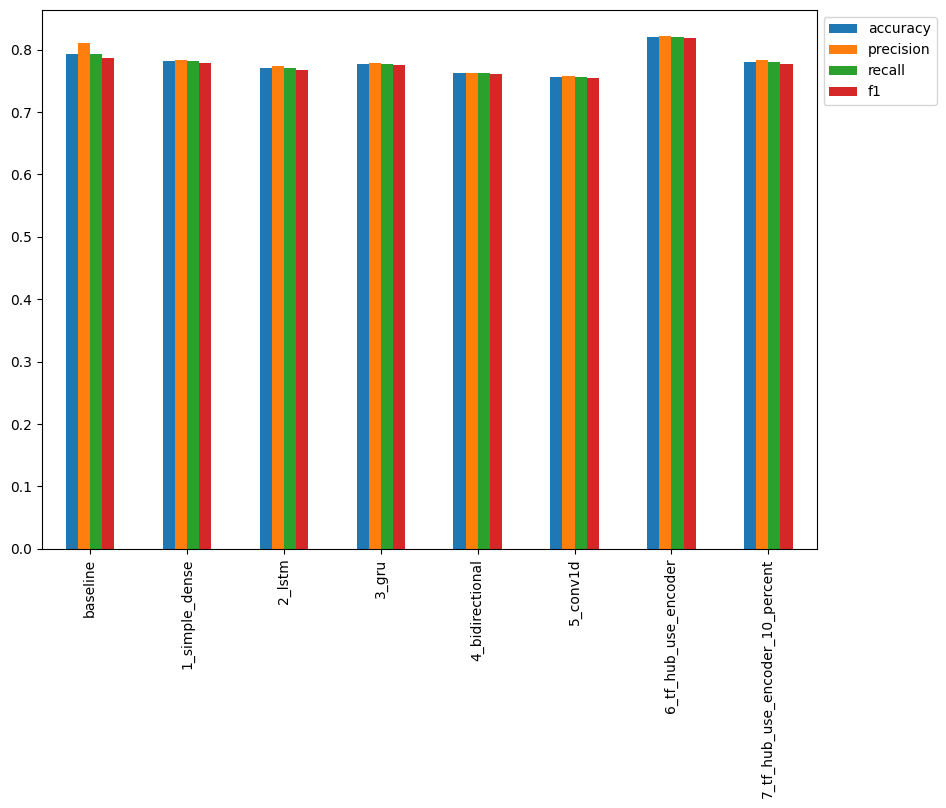

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

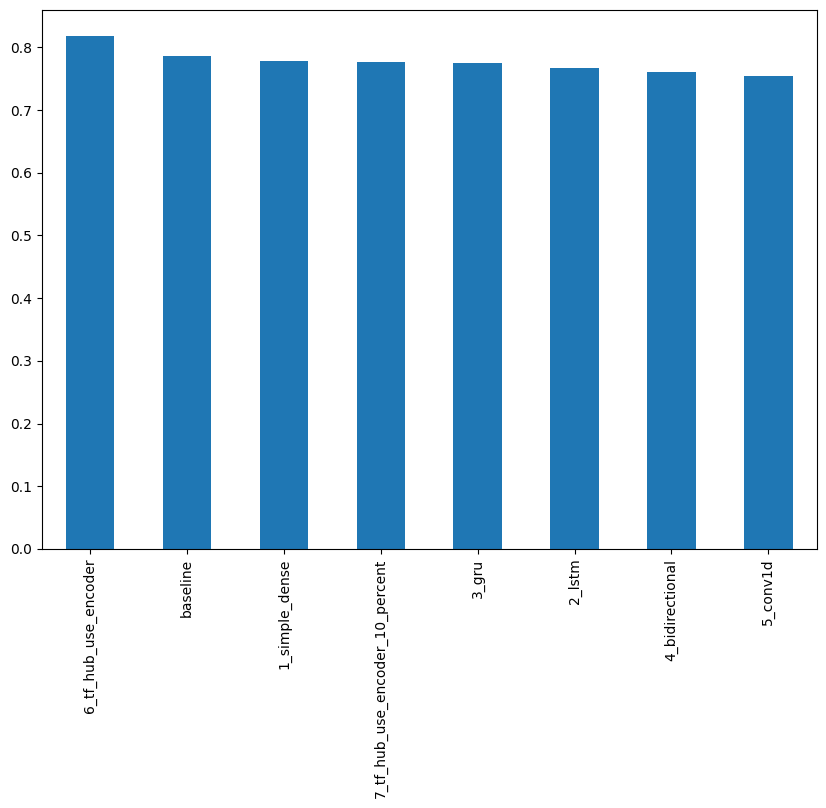

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values(by='f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

## Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using TensorBoard.dev

> **Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP modelling Experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# See the previous TensorBoard Dev experiments you've run...
# !tensorboard dev list

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow_hub as hub
# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                     custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 21ms/step - loss: 0.4260 - accuracy: 0.8202


[0.4259933829307556, 0.8202099800109863]

In [ ]:
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8223219905078891,
 'recall': 0.8202099737532809,
 'f1': 0.8188242643827762}

Now let's save to the `SavedModel` format...

In [ ]:
# Save TF Hub Sentence Encoder model to SavedFormat (default)
model_6.save('model_6_SavedModel_format')

In [ ]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [ ]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 13ms/step - loss: 0.4260 - accuracy: 0.8202


[0.4259933829307556, 0.8202099800109863]

In [ ]:
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8223219905078891,
 'recall': 0.8202099737532809,
 'f1': 0.8188242643827762}

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor

--2023-09-16 19:40:50--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  40.5MB/s    in 19s     

2023-09-16 19:41:10 (48.2 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [ ]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 13ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

24/24 [==============================] - 1s 20ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred':model_6_pretrained_preds,
                       'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)})
val_df


,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949


Let's remind ourselves of the target labels...
* `0` = not diaster
* `1` = diaster

In [ ]:
most_wrong.tail()

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Text:\n{text}\n')
  print('----\n')

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [ ]:
# Check the false negatives (model predicted 1 when should've been 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Text:\n{text}\n')
  print('----\n')

Target: 1, Pred: 0.0, Prob: 0.06730345636606216
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.055075839161872864
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.054603397846221924
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.05459701269865036
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963730648159981
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.04391849413514137
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making predictions on the test dataset

In [ ]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as an input
  pred = tf.round(pred_prob)
  print(f'Pred: {int(pred)}, Prob: {pred_prob}')
  print(f'Text:\n{test_sample}\n')
  print('-----\n')

1/1 [==============================] - 0s 124ms/step
Pred: 0, Prob: 0.04864754155278206
Text:
What a nice hat?

-----

1/1 [==============================] - 0s 68ms/step
Pred: 0, Prob: 0.0990820974111557
Text:
Time to enjoy summer in a crash course of two weeks... I will never take summer classes again. (That's a lie)

-----

1/1 [==============================] - 0s 66ms/step
Pred: 0, Prob: 0.032641783356666565
Text:
@AshNiggas tink ...

-----

1/1 [==============================] - 0s 69ms/step
Pred: 0, Prob: 0.15037605166435242
Text:
fear the fever Can you feel it now? I feel the fire Burning belo-ooow It's gonna trick ya Swallow you who-ooo-ole #MTVHottest Justin Bieber

-----

1/1 [==============================] - 0s 69ms/step
Pred: 1, Prob: 0.9240638017654419
Text:
BREAKING NEWS: Australia collapse to a hapless 60 all out at Trent Bridge http://t.co/O2CFWDzZld

-----

1/1 [==============================] - 0s 73ms/step
Pred: 0, Prob: 0.0694870874285698
Text:
Mouna gonna get me 

## Your challenge... predicting on Tweets from the wild

Go to your favourite Twitter account and copy one of their latest Tweets.

Then pass the Tweet through our trained model.

Is that Tweet a diaster or not diaster (according to the model)? is the model right or wrong?

In [ ]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [ ]:
tweet_1 = 'After receiving a blood transfusion 3,000 feet below ground, ailing American caver Mark Dickey was stable. Saving his life would require an arduous ascent'

In [ ]:
tweet_2 = 'Rosh Hashanah doesn’t just mark the beginning of the Jewish New Year—it’s also the start of the high holy days. Here’s what you need to know about how the holiday is celebrated'

In [ ]:
tweet_3 = "SCARY 😳. Brute force of mother nature ravaging through city, destroying everything in its way and reclaiming it's territory. 😧#StormDaniel #HurricaneHilary #hurricanelee #HurricaneSeason"

In [ ]:
tweet_4 = "Radar showing bands of #rain from #HurricaneLee moving across Nova Scotia, #Canada "

In [ ]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=tweet_1)

1/1 [==============================] - 0s 50ms/step
Pred: 1.0 (real disaster) Prob: 0.5717278718948364
Text:
After receiving a blood transfusion 3,000 feet below ground, ailing American caver Mark Dickey was stable. Saving his life would require an arduous ascent


In [ ]:
## The speed/score tradeoff
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8223219905078891,
 'recall': 0.8202099737532809,
 'f1': 0.8188242643827762}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## The speed/score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  '''
  Times how long a model takes to make predictions on samples.
  '''
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time / len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 15ms/step


(0.4572873789999221, 0.0006001146706035724)

In [ ]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                              samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.060951221999971494, 7.998848031492322e-05)

In [ ]:
# Get the results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentene_encoder')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1-score')

<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)>

<Figure size 1000x700 with 0 Axes>

## 🛠 Exercises

1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.
2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?
3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting `training=True` when instantiating it as a Keras layer.

```
We can use this encoding layer in place of our text_vectorizer and embedding layer

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```
4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?
5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?
6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

## 📖 Extra-curriculum

To practice what you've learned, a good idea would be to spend an hour on 3 of the following (3-hours total, you could through them all if you want) and then write a blog post about what you've learned.

* For an overview of the different problems within NLP and how to solve them read through:
 * [A Simple Introduction to Natural Language Processing](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32)
 * [How to solve 90% of NLP problems: a step-by-step guide](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)
* Go through [MIT's Recurrent Neural Networks lecture](https://youtu.be/SEnXr6v2ifU). This will be one of the greatest additions to what's happening behind the RNN model's you've been building.
* Read through the [word embeddings page on the TensorFlow website](https://www.tensorflow.org/tutorials/text/word_embeddings). Embeddings are such a large part of NLP. We've covered them throughout this notebook but extra practice would be well worth it. A good exercise would be to write out all the code in the guide in a new notebook.
* For more on RNN's in TensorFlow, read and reproduce [the TensorFlow RNN guide](https://www.tensorflow.org/guide/keras/rnn). We've covered many of the concepts in this guide, but it's worth writing the code again for yourself.
* Text data doesn't always come in a nice package like the data we've downloaded. So if you're after more on preparing different text sources for being with your TensorFlow deep learning models, it's worth checking out the following:
 * [TensorFlow text loading tutorial](https://www.tensorflow.org/tutorials/load_data/text).
  * [Reading text files with Python](https://realpython.com/read-write-files-python/) by Real Python.
* This notebook has focused on writing NLP code. For a mathematically rich overview of how NLP with Deep Learning happens, read [Standford's Natural Language Processing with Deep Learning lecture notes Part 1](https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf).  
  * For an even deeper dive, you could even do the whole [CS224n](http://web.stanford.edu/class/cs224n/) (Natural Language Processing with Deep Learning) course.
* Great blog posts to read:
  * Andrei Karpathy's [The Unreasonable Effectiveness of RNNs](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) dives into generating Shakespeare text with RNNs.
  * [Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794) by Mauro Di Pietro. An overview of different techniques for turning text into numbers and then classifying it.
  * [What are word embeddings?](https://machinelearningmastery.com/what-are-word-embeddings/) by Machine Learning Mastery.
* Other topics worth looking into:
  * [Attention mechanisms](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/). These are a foundational component of the transformer architecture and also often add improvments to deep NLP models.
  * [Transformer architectures](http://jalammar.github.io/illustrated-transformer/). This model architecture has recently taken the NLP world by storm, achieving state of the art on many benchmarks. However, it does take a little more processing to get off the ground, the [HuggingFace Models (formerly HuggingFace Transformers) library](https://huggingface.co/models/) is probably your best quick start.
    * And now [HuggingFace even have their own course](https://huggingface.co/course/chapter1) on how their library works! I haven't done it but anything HuggingFace makes is world-class.

